Here we will implement Decision Tree and Random Forest Classifiers from [sklearn](http://scikit-learn.org/stable/). They don't support [categorical variables](https://stats.stackexchange.com/questions/152433/will-decision-trees-perform-splitting-of-nodes-by-converting-categorical-values) without [one-hot encoding](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/).

## TODO: Try using H20 instead and compare. (https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)

# Decision Tree

For now, let's implement them for two datasets: 

1. Dataset without column `stalk-root`.
2. Raw dataset with `?` as `np.NaN`.
3. Raw dataset (treating `?` as possible value of `stalk-root`).
4. Dataset without missing values across all features.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [48]:
# Loads the data from UCI Machine Learning Repo into a pandas DataFrame
mushrooms = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data")
columns = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat']
# Names the columns 
mushrooms.columns = columns
# Replace "?" (represents missing values on UCI Machine Learning Repo) witn np.NaN
mushrooms.replace('?', np.NaN, inplace = True)

# 1.

## Data Preprocessing

In [49]:
# Gets a dataset without the problematic feature
mushrooms_no_stalk_root = mushrooms.drop("stalk-root", axis = 1)

# Gets the predictor features 
X = mushrooms_no_stalk_root.drop(["class"], axis=1)
# And encodes them (they are all categorical)
X = pd.get_dummies(X).values
# Gets the target feature (binary)
y = mushrooms_no_stalk_root["class"].values

le = LabelEncoder()
# Encodes the target
y = le.fit_transform(y)

# Splits between training and testing, stratifying by the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

# No need to standardize as we only have 1s and 0s for all of our variables (they are all categorical)
#std_scaler = StandardScaler()
# Standardizes training data
#X_train = std_scaler.fit_transform(X_train)
# and testing data with training data's mean and stdv
#X_test = std_scaler.transform(X_test)

No need to standardize as we only have 1s and 0s for all of our variables (they are all categorical). This also makes it easier to interpret the decission tree. 


In [50]:
# No need to standardize as we only have 1s and 0s for all of our variables (they are all categorical)
#std_scaler = StandardScaler()
# Standardizes training data
#X_train = std_scaler.fit_transform(X_train)
# and testing data with training data's mean and stdv
#X_test = std_scaler.transform(X_test)

for i in X:
    if 1 not in i or 0 not in i:
        print("They are not all categorical")

In [51]:
mushrooms_no_stalk_root["class"].value_counts()

e    4208
p    3915
Name: class, dtype: int64

The classes are very similar in frequency, so let's `class_weight = balanced` won't have a big impact (actually gives the same score, as it can be seen below).

## Training and testing

In [52]:
tree = DecisionTreeClassifier(random_state = 0)
# Fits the training data to a Decision Tree
tree.fit(X_train, y_train)
# Evaluates the model using the testing data
tree.score(X_test, y_test)

1.0

In [53]:
tree_balanced = DecisionTreeClassifier(random_state = 0, class_weight="balanced")
# Fits the training data to a Decision Tree
tree_balanced.fit(X_train, y_train)
# Evaluates the model using the testing data
tree_balanced.score(X_test, y_test)

1.0

Well and we have a perfect score right at the start, which is actually to be expected as we have so much data and the nature of the decision tree is very well suited for this problem. (However, let's cross-validate later).

## Visualization and evaluation

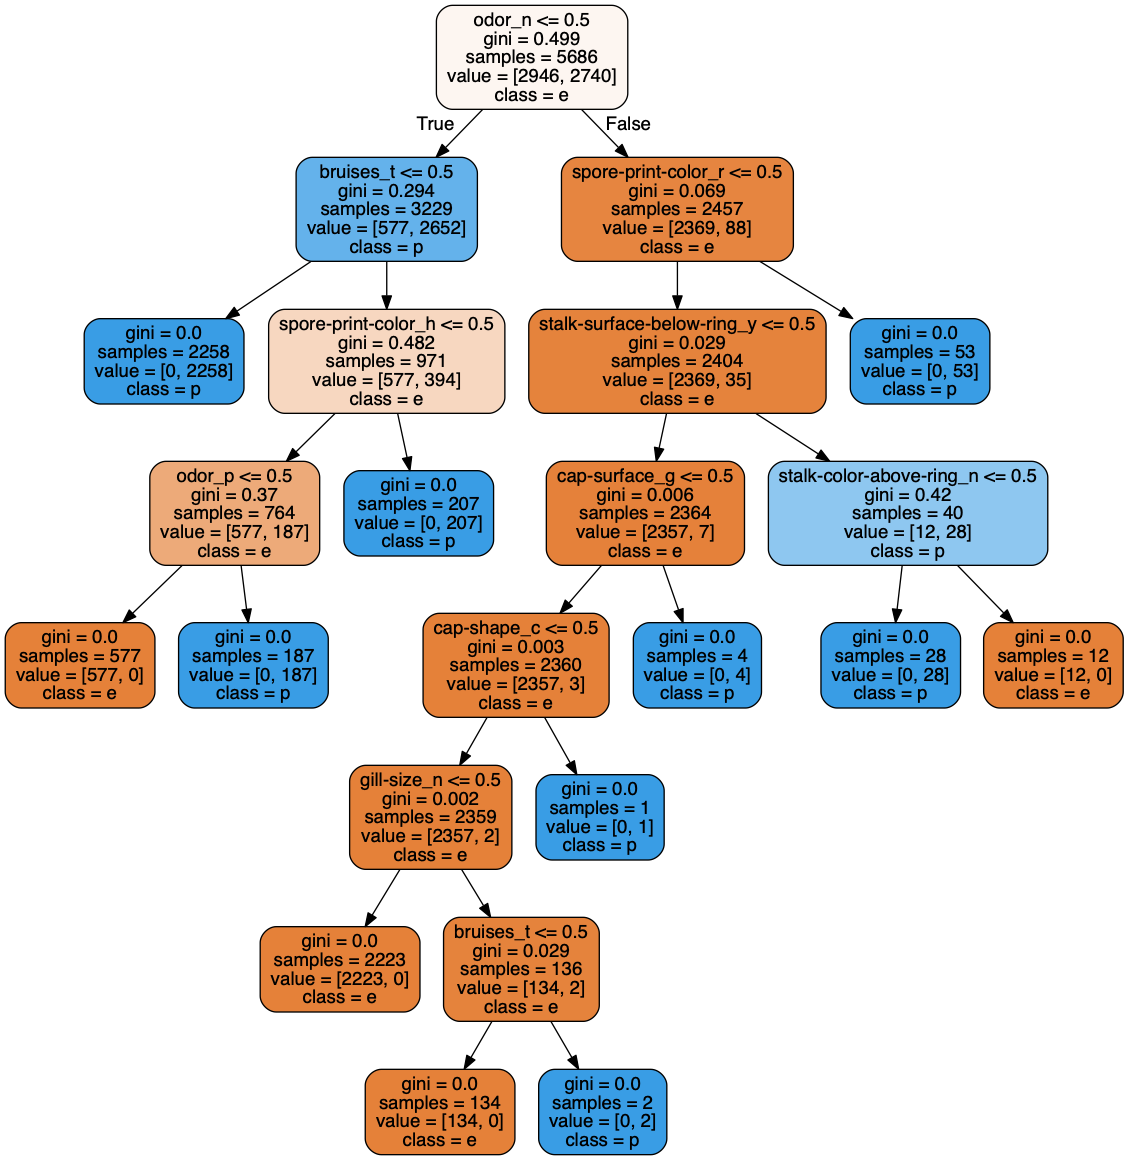

In [54]:
# Prints out the learned tree
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=['e', # e comes firts because it is assigned a 0 by the LabelEncoder
                                        'p'],
                           feature_names=pd.get_dummies(mushrooms_no_stalk_root.drop(["class"], axis=1)).columns,
                           out_file=None) 

graph = graph_from_dot_data(dot_data) 

Image(graph.create_png()) 

As we can see, an odor of "n" and a bruises of "t" make the mushroom automatically posionous. 

## TODO: CHECK WHAT THIS MEANS AND ALSO INTERPRET A BIT MORE

In [55]:
mushrooms[mushrooms["odor"] != "n"][mushrooms["bruises"] != "t"]["class"].value_counts()

p    3252
Name: class, dtype: int64

In [56]:
mushrooms_no_stalk_root["odor"].unique()

array(['a', 'l', 'p', 'n', 'f', 'c', 'y', 's', 'm'], dtype=object)

## TODO : USE OTHER EVALUTATION METHODS, like decision matrix to make sure we have no false positives (positive = edible, I think?).
## TODO: Check numer data points vs numer of combinations of feature values, to explain why the decission and other class algo give such good or even perfect scores.

## Cross-validation and Hyperparameter Tuning

In [57]:
pipe = Pipeline([('clf', DecisionTreeClassifier(random_state = 0))])

In [58]:
param_grid = {'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}

In [68]:
gs = GridSearchCV(estimator=pipe,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=StratifiedKFold(n_splits=10,
                                         shuffle=True,
                                         random_state=0)) 
# Fit the pipeline
gs = gs.fit(X_train, y_train)
    
# Update best_score_param_estimators
print(gs.best_score_, gs.best_params_, gs.best_estimator_)

0.9998241294407316 {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2} Pipeline(memory=None,
     steps=[('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))])


Alright, so even if we got an almost perfect score, the thing is our data is not the real one because one column is missing!! But it really does not matter as long as we have the rest of the features, but imagine if we don't have some of such features, and we need `stalk-root` to make a decision...

# 2. 

Alright, let's preprocess the data again without dropping the problematic column and score the model.

In [69]:
# Gets the predictor features 
X = mushrooms.drop(["class"], axis=1)
# And encodes them (they are all categorical)
X = pd.get_dummies(X).values
# Gets the target feature (binary)
y = mushrooms["class"].values

le = LabelEncoder()
# Encodes the target
y = le.fit_transform(y)

# Splits between training and testing, stratifying by the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

tree = DecisionTreeClassifier(random_state = 0)
# Fits the training data to a Decision Tree
tree.fit(X_train, y_train)
# Evaluates the model using the testing data
tree.score(X_test, y_test)

1.0

It seems the model performs exacty the same, even with missing values present, because the `stalk_root` feature is not important?? (I think essential is a better word), meaning that the edibility can be determined by a combination of the rest of the features, without using `stalk_root`. 

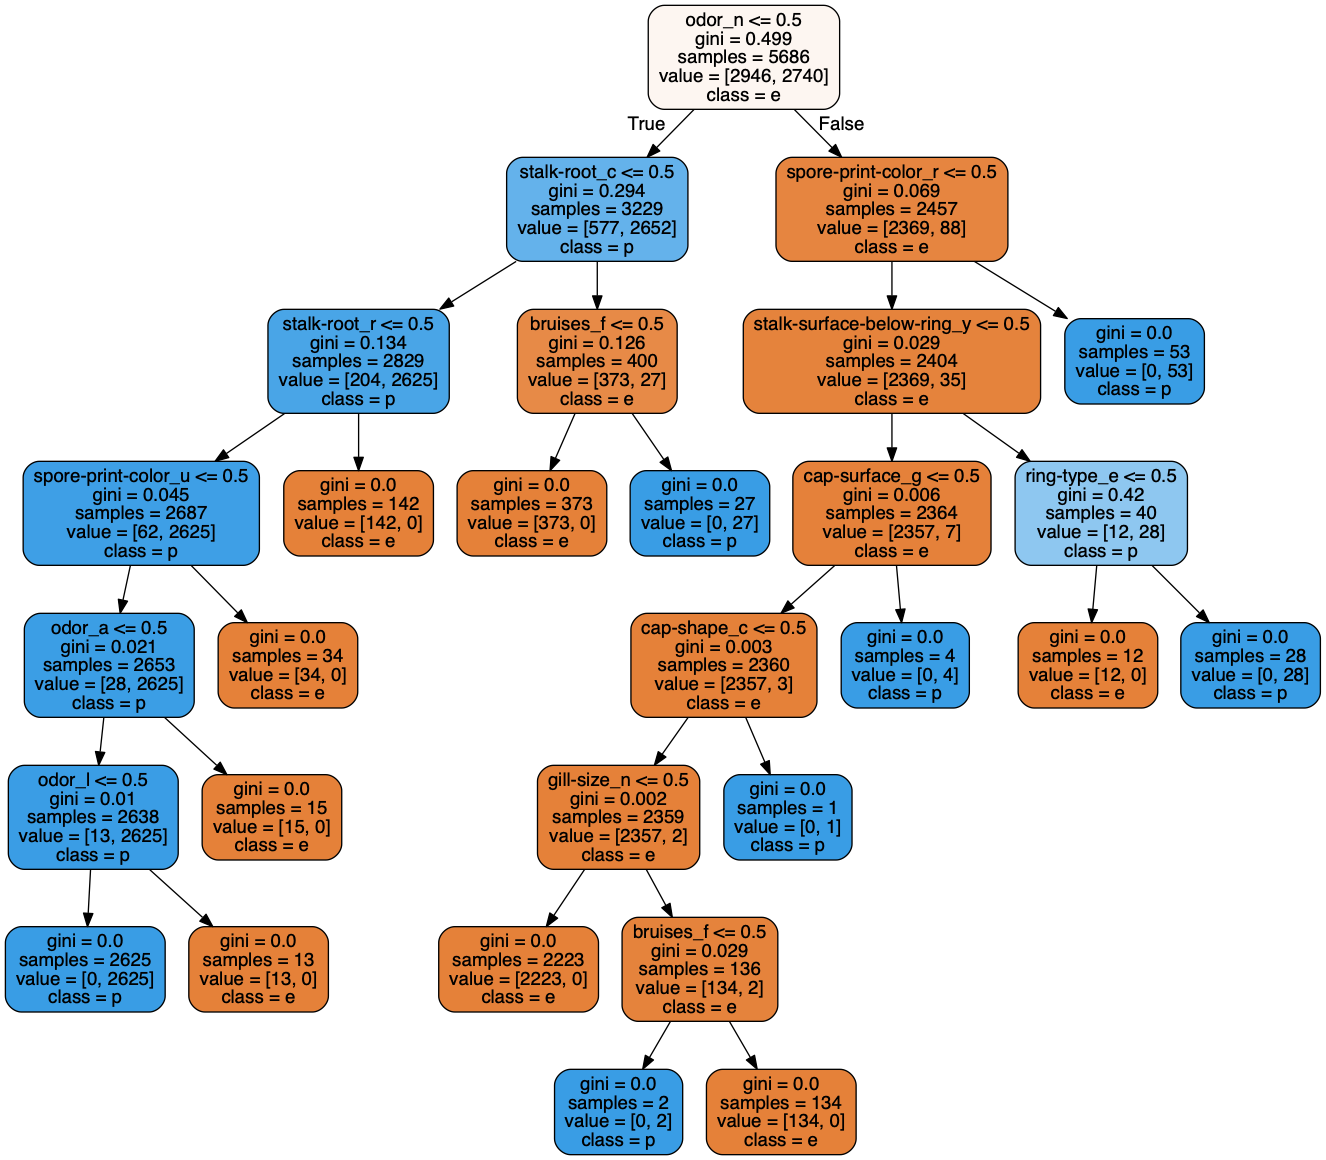

In [70]:
# Prints out the learned tree
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=['e', # e comes firts because it is assigned a 0 by the LabelEncoder
                                        'p'],
                           feature_names=pd.get_dummies(mushrooms.drop(["class"], axis=1)).columns,
                           out_file=None) 

graph = graph_from_dot_data(dot_data) 

Image(graph.create_png()) 

Oh wait but `stalk-root` is almost at the top of the tree!!! This means that it is important, but that the model can perform equally well if we have lots of other features to go by.

# 3. 

In [72]:
mushrooms_ = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data")
# Names the columns 
mushrooms_.columns = columns
# Gets the predictor features 
X = mushrooms_.drop(["class"], axis=1)
# And encodes them (they are all categorical)
X = pd.get_dummies(X).values
# Gets the target feature (binary)
y = mushrooms_["class"].values

le = LabelEncoder()
# Encodes the target
y = le.fit_transform(y)

# Splits between training and testing, stratifying by the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

tree = DecisionTreeClassifier(random_state = 0)
# Fits the training data to a Decision Tree
tree.fit(X_train, y_train)
# Evaluates the model using the testing data
tree.score(X_test, y_test)

1.0

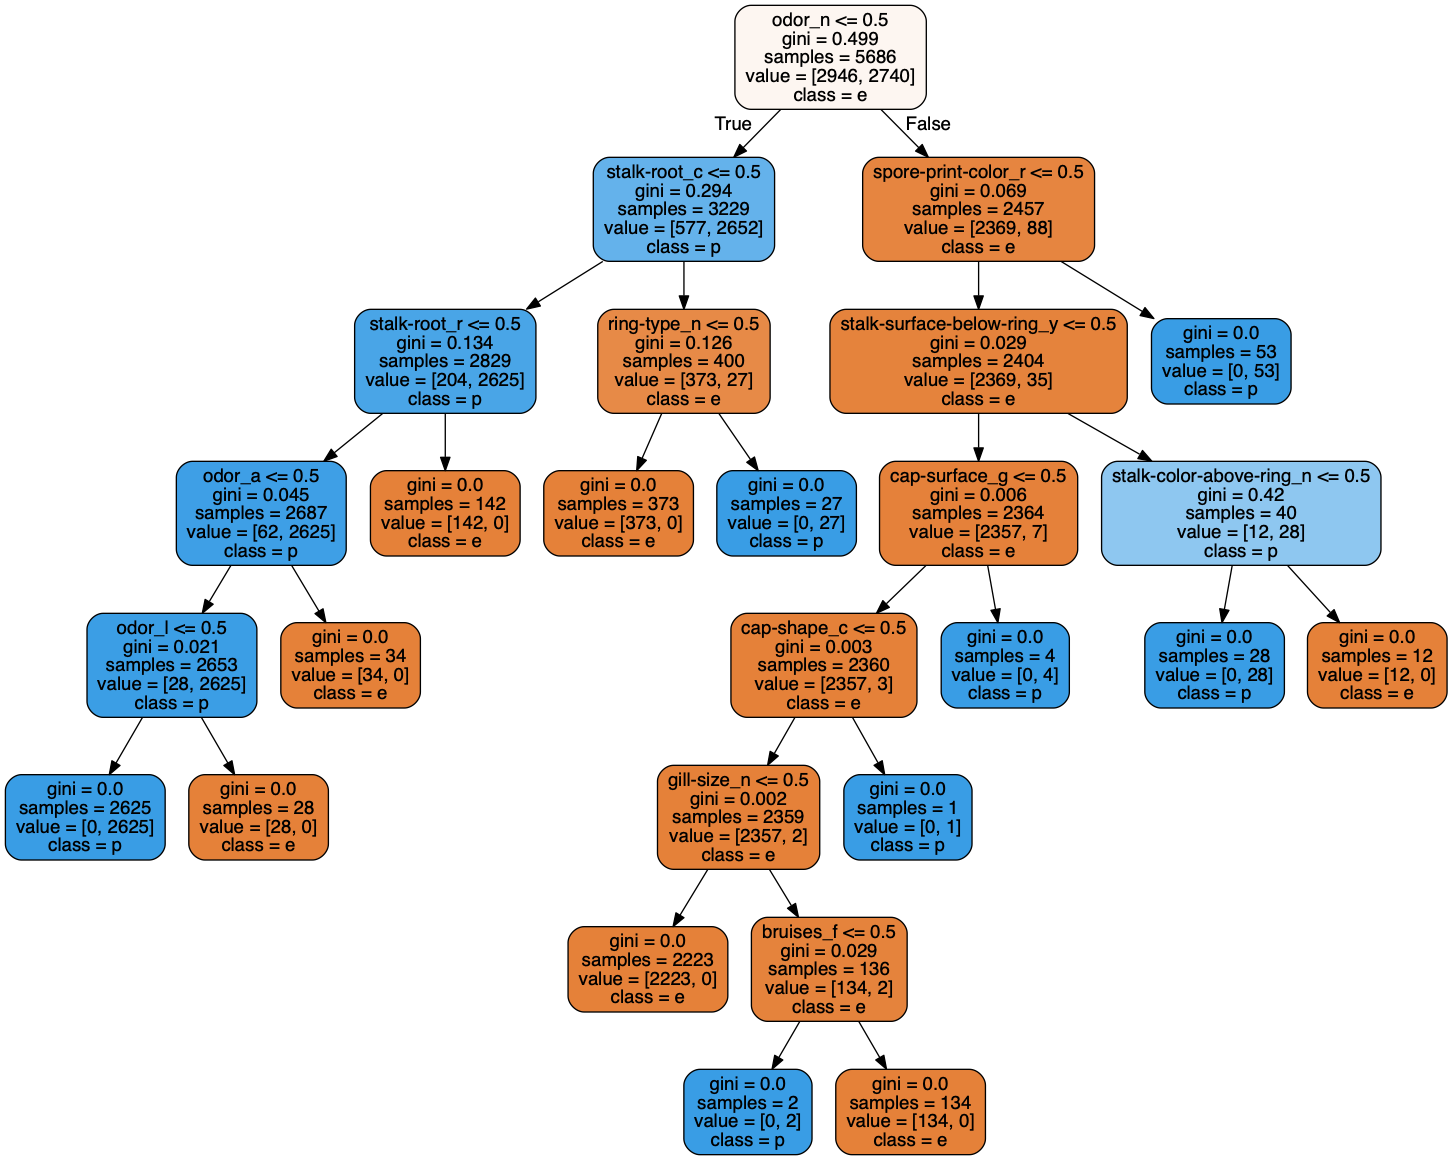

In [73]:
# Prints out the learned tree
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=['e', # e comes firts because it is assigned a 0 by the LabelEncoder
                                        'p'],
                           feature_names=pd.get_dummies(mushrooms_.drop(["class"], axis=1)).columns,
                           out_file=None) 

graph = graph_from_dot_data(dot_data) 

Image(graph.create_png()) 

*3.* doesn't make a difference to *2.*, because as we can see, `stalk-root_?` doesn't appear on the nodes/leafes??.

# 4.
Now let's drop all the rows with missing values.

In [74]:
# Drops missing values
mushrooms_without_NaN = mushrooms.dropna()
# Gets the predictor features 
X = mushrooms_without_NaN.drop(["class"], axis=1)
# And encodes them (they are all categorical)
X = pd.get_dummies(X).values
# Gets the target feature (binary)
y = mushrooms_without_NaN["class"].values

le = LabelEncoder()
# Encodes the target
y = le.fit_transform(y)

# Splits between training and testing, stratifying by the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

tree = DecisionTreeClassifier(random_state = 0)
# Fits the training data to a Decision Tree
tree.fit(X_train, y_train)
# Evaluates the model using the testing data
tree.score(X_test, y_test)

1.0

In [75]:
pipe = Pipeline([('clf', DecisionTreeClassifier(random_state = 0))])

param_grid = {'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}

gs = GridSearchCV(estimator=pipe,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=StratifiedKFold(n_splits=10,
                                         shuffle=True,
                                         random_state=0)) 
# Fit the pipeline
gs = gs.fit(X_train, y_train)
    
# Update best_score_param_estimators
print(gs.best_score_, gs.best_params_, gs.best_estimator_)

1.0 {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2} Pipeline(memory=None,
     steps=[('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))])


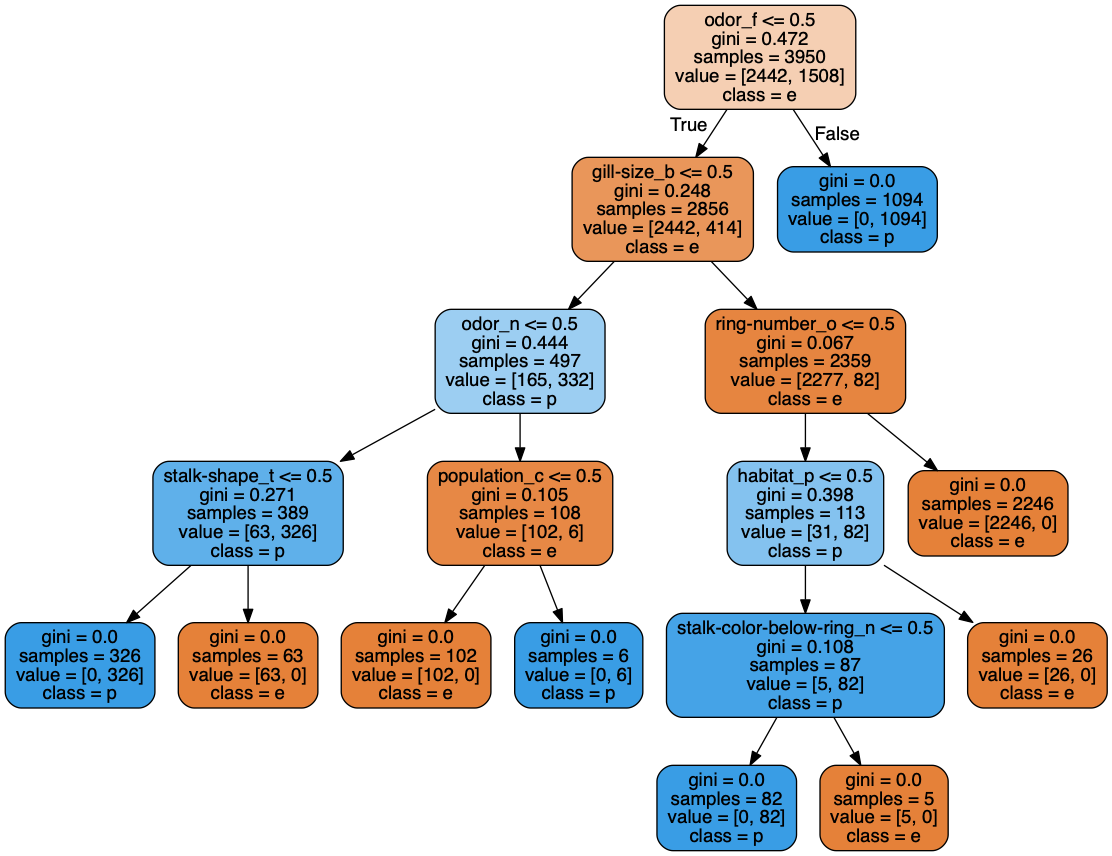

In [76]:
# Prints out the learned tree
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=['e', # e comes firts because it is assigned a 0 by the LabelEncoder
                                        'p'],
                           feature_names=pd.get_dummies(mushrooms_without_NaN.drop(["class"], axis=1)).columns,
                           out_file=None) 

graph = graph_from_dot_data(dot_data) 

Image(graph.create_png()) 

We get a perfect accuracy but the tree has changed. It doesn't even use `odor_n` until the third node. If it has odor `f`, then it's poisonous. Mmm...

In [77]:
mushrooms_without_NaN[mushrooms_without_NaN["odor"] == "f"]["class"].value_counts()

p    1584
Name: class, dtype: int64

In [78]:
mushrooms[mushrooms["odor"] == "f"]["class"].value_counts()

p    2160
Name: class, dtype: int64

## TODO: Explain this a bit more

Now, as odor is kinda a subjective feature, we need to spot some other relevant features. For that, we are going to use a random forest.

# Random Forest

For now, let's implement them for two datasets: 

1. Dataset without column `stalk-root`.
2. Raw dataset with `?` as `np.NaN`.
3. Raw dataset (treating `?` as possible value of `stalk-root`).
4. Dataset without missing values across all features.

In [79]:
from sklearn.ensemble import RandomForestClassifier

# 1.

In [80]:
# Gets a dataset without the problematic feature
mushrooms_no_stalk_root = mushrooms.drop("stalk-root", axis = 1)

# Gets the predictor features 
X = mushrooms_no_stalk_root.drop(["class"], axis=1)
# And encodes them (they are all categorical)
X = pd.get_dummies(X).values
# Gets the target feature (binary)
y = mushrooms_no_stalk_root["class"].values

le = LabelEncoder()
# Encodes the target
y = le.fit_transform(y)

# Splits between training and testing, stratifying by the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

In [81]:
forest = RandomForestClassifier(random_state = 0)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

1.0

In [82]:
pipe = Pipeline([('clf', RandomForestClassifier(random_state = 0))])

In [83]:
param_grid = {'clf__n_estimators': [2, 10, 30],
               'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}

In [84]:
gs = GridSearchCV(estimator=pipe,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=StratifiedKFold(n_splits=10,
                                         shuffle=True,
                                         random_state=0)) 
# Fit the pipeline
gs = gs.fit(X_train, y_train)
    
# Update best_score_param_estimators
print(gs.best_score_, gs.best_params_, gs.best_estimator_)

1.0 {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 10} Pipeline(memory=None,
     steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])


In [85]:
forest = gs.best_estimator_ # It's the default random forest from sklearn
# Fits the training data to a Decision Tree
forest.fit(X_train, y_train)
# Evaluates the model using the testing data
forest.score(X_test, y_test)

1.0

In [86]:
forest.score(X_train, y_train)

1.0

Well as we expected, the random forest performs perfectly even without `stalk-root`. However, let's do it with all the features to see the most significant ones and see where `stalk-root` lands in there. 

# 2. 

In [87]:
# Gets the predictor features 
X = mushrooms.drop(["class"], axis=1)
# And encodes them (they are all categorical)
X = pd.get_dummies(X).values
# Gets the target feature (binary)
y = mushrooms["class"].values

le = LabelEncoder()
# Encodes the target
y = le.fit_transform(y)

# Splits between training and testing, stratifying by the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

forest = RandomForestClassifier(random_state = 0)
# Fits the training data to a Decision Tree
forest.fit(X_train, y_train)
# Evaluates the model using the testing data
forest.score(X_test, y_test)

1.0

Now let's get the [features importances](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/).

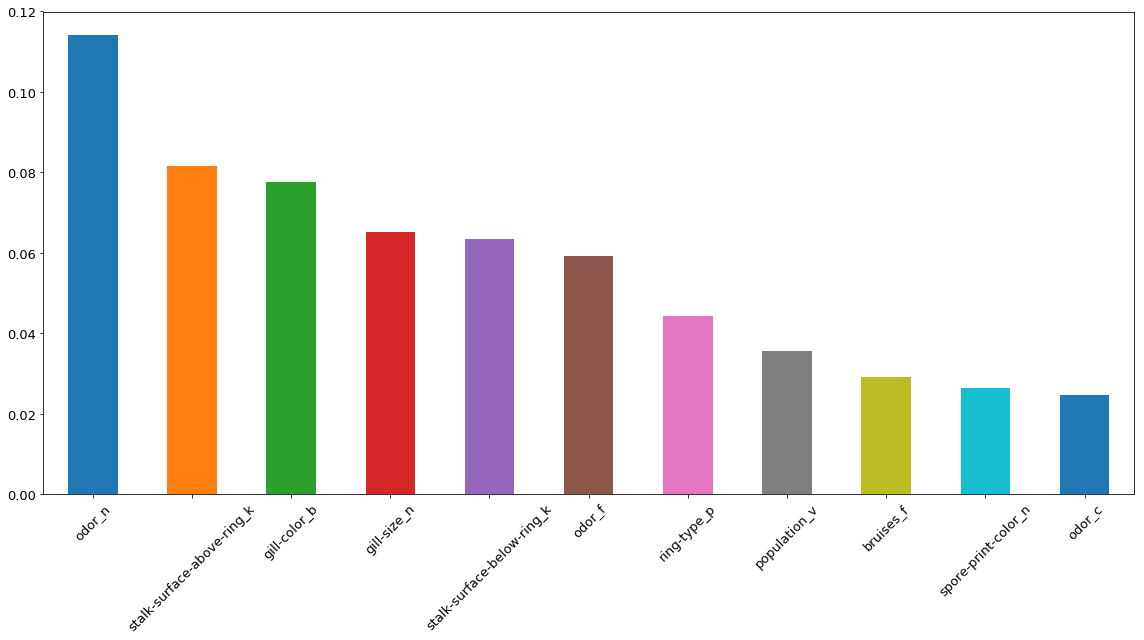

In [88]:
# Gets the importance of each features
importances = forest.feature_importances_
# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
f_importances = pd.Series(importances, pd.get_dummies(mushrooms.drop(["class"], axis=1)).columns)

# Sort the array in descending order of the importances
f_importances = f_importances.sort_values(ascending=False)

# Get the top 10 most important features
f_importances_top_10 = f_importances.iloc[0:11]

# Draws the bar Plot for the 10 most important features 
f_importances_top_10.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=45, fontsize=13)

# Show the plot
plt.tight_layout()
plt.show()

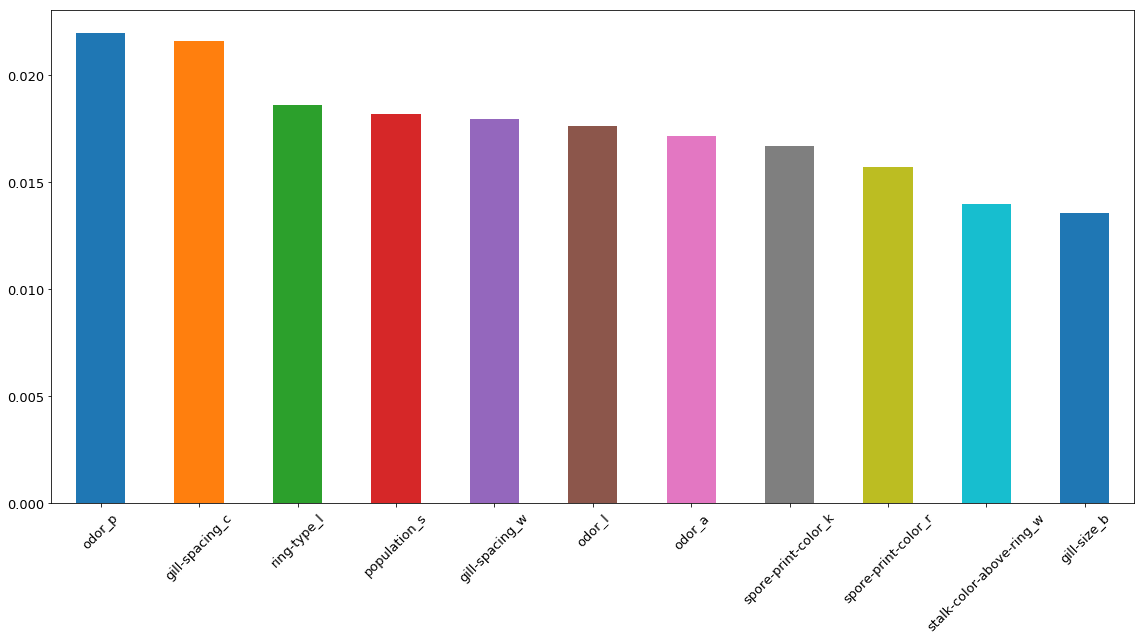

In [90]:
f_importances_top_20 = f_importances.iloc[11:22] 
f_importances_top_20.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=45, fontsize=13)
plt.tight_layout()
plt.show()

## TODO: Do the same as below, to get the minimum number of top dummy features to get a perfect score

Let's compute the original features importance by adding up the importances of each of its corresponding dummy variables.

In [91]:
# Names of the dummy variables
features = pd.get_dummies(mushrooms.drop(["class"], axis=1)).columns
# Computes this again because we don't wont it sorted
f_importances = pd.Series(importances, features) 
importa_dict = {}
# For each feature in the original dataframe
for i in mushrooms.drop("class", axis = 1).columns:
    # Assign this feature as key and the sum of the importances of every dummy variable corresponding to it as value
    importa_dict[i] = f_importances[features.str.contains(i)].sum() # Subsets f_importances with the columns containing the name 
    # "i", which is the original feature name, so it gets all the dummy columns "i_..."
feat_importances = pd.Series(importa_dict).sort_values(ascending=False)

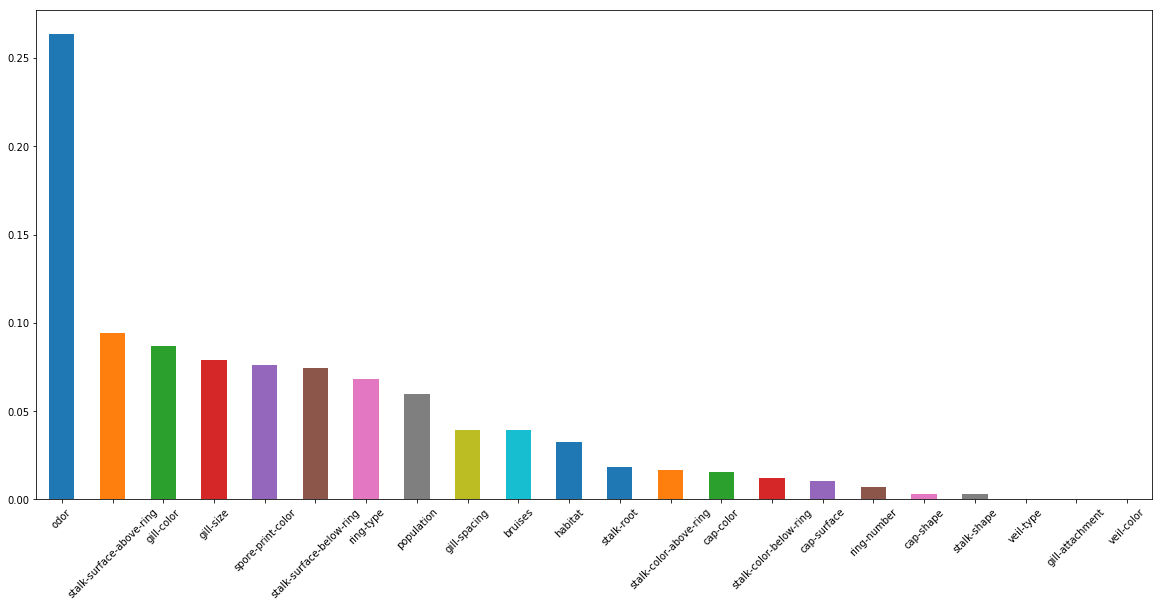

In [92]:
feat_importances.plot(kind='bar', figsize=(20,9), rot=45, fontsize=10)
plt.show()

As we already saw with the decision trees, `odor` seems to be the most relevant feature for prediction, with its importance being actually more than double the second most important feauture (`gill-color`). 

Let's see how many features we need to get a perfect score.

In [93]:
def rf_score(n_features):
    
    """"
    Returns the score of the random forest using the n_features most important features
    """
    
    # Slices the list of names of features sorted by importance from the most important until n_features
    X = mushrooms[list(feat_importances.index)[0:n_features]]
    X = pd.get_dummies(X).values
    y = mushrooms["class"].values
    le = LabelEncoder()
    y = le.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)
    forest = RandomForestClassifier(random_state = 0)
    forest.fit(X_train, y_train)
    return forest.score(X_test, y_test)

In [94]:
for i in range(1, len(feat_importances.index)):
    if rf_score(i) == 1:
        print(i)
        break

7


So we only need 7 features out of the original 23 to get 100% percent accuracy! This should make it easier for people to identify the poisonous mushrooms! So if they have a computer (maybe phone, we could probably write an app), they can run this Random Forest on a row of data where they fill the value of every feature and it would give them an answer in order to eat the mushrooms or not.  
However, we also wanted to just tell them a way to categorize the poisonous mushrooms without using any machine... this can easily be done with decision trees!

In [95]:
list(feat_importances.index)[0:7]

['odor',
 'stalk-surface-above-ring',
 'gill-color',
 'gill-size',
 'spore-print-color',
 'stalk-surface-below-ring',
 'ring-type']

In [96]:
X = mushrooms[list(feat_importances.index)[0:7]]
X = pd.get_dummies(X).values
y = mushrooms["class"].values
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)
tree = DecisionTreeClassifier(random_state = 0)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

1.0

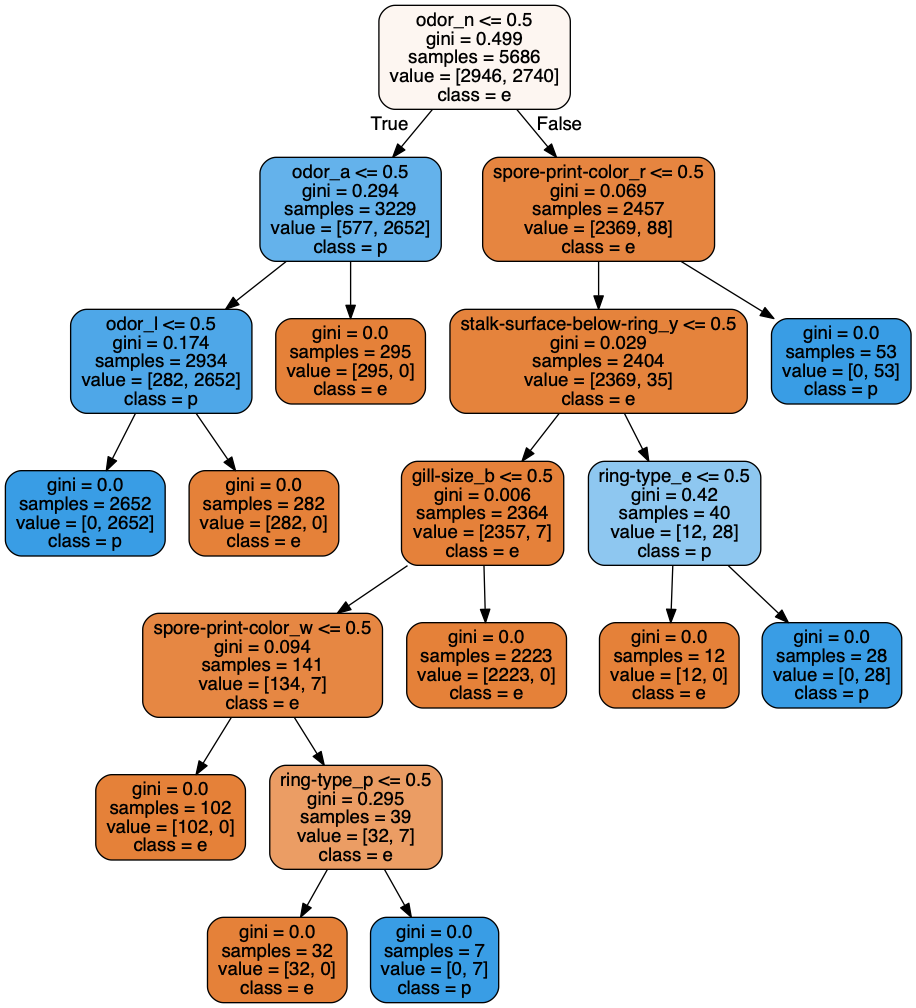

In [98]:
# Prints out the learned tree
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=['e', # e comes firts because it is assigned a 0 by the LabelEncoder
                                        'p'],
                           feature_names=pd.get_dummies(mushrooms[list(feat_importances.index)[0:7]]).columns,
                           out_file=None) 

graph = graph_from_dot_data(dot_data) 

Image(graph.create_png()) 

In [100]:
X = mushrooms.drop("class", axis = 1)
X = pd.get_dummies(X)[["odor_n", "odor_a",
                       "odor_l", "spore-print-color_r", "stalk-surface-below-ring_y",
                       "gill-size_b", "ring-type_e", "spore-print-color_w", "ring-type_p"]]
y = mushrooms["class"].values
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)
tree = DecisionTreeClassifier(random_state = 0)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

1.0

# TODO: Try to get a perfect forest/tree but without odor, because it's a hard feature to tell. Actually try to get a perfect model only
# with features that are easy to classify